In [1]:
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
import nltk
import sklearn
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
data = pd.read_csv("data/IMDB Dataset.csv")
print (data.shape)
data.head(10)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [3]:
data.isnull().sum()

review       0
sentiment    0
dtype: int64

In [4]:
data.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [5]:
def remove_html(text):
    bs = BeautifulSoup(text, "html.parser")
    return ' ' + bs.get_text() + ' '

def keep_only_letters(text):
    text=re.sub(r'[^a-zA-Z\s]',' ',text)
    return text

def convert_to_lowercase(text):
    return text.lower()

def clean_reviews(text):
    text = remove_html(text)
    text = keep_only_letters(text)
    text = convert_to_lowercase(text)
    return text

In [6]:
data['review'] = data['review'].apply(lambda review: clean_reviews(review))

In [7]:
data['review_word_length'] = [len(review.split()) for review in data['review']]

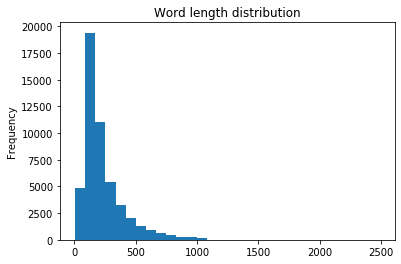

In [8]:
data['review_word_length'].plot(kind='hist', bins=30)
plt.title('Word length distribution')
plt.show()

## Splitting into Training and Test data

In [9]:
imdb_train = data[:40000]
imdb_test = data[40000:]

## Vocabulary

In [10]:
from collections import Counter

counter = Counter([words for reviews in imdb_train['review'] for words in reviews.split()])
df = pd.DataFrame()
df['key'] = counter.keys()
df['value'] = counter.values()
df.sort_values(by='value', ascending=False, inplace=True)
print(df.shape)
df.head()

(92279, 2)


,key,value
2,the,533072
35,and,259694
47,a,258257
1,of,230754
58,to,213961


In [11]:
df[:10000].value.sum()/df.value.sum()

0.9477437089109378

In [12]:
top_10k_words = list(df[:10000].key.values)

## Input_Encoding

In [13]:
def get_encoded_input(review):
    words = review.split()
    if len(words) > 500:
        words = words[:500]
    encoding = []
    for word in words:
        try:
            index = top_10k_words.index(word)
        except:
            index = 10000
        encoding.append(index)
    while len(encoding) < 500:
        encoding.append(10001)
    return encoding

training_data = np.array([get_encoded_input(review) for review in imdb_train['review']])
testing_data = np.array([get_encoded_input(review) for review in imdb_test['review']])
print (training_data.shape, testing_data.shape)

(40000, 500) (10000, 500)


## Output Encoding

In [14]:
train_labels = [1 if sentiment=='positive' else 0 for sentiment in imdb_train['sentiment']]
test_labels = [1 if sentiment=='positive' else 0 for sentiment in imdb_test['sentiment']]
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)
print (train_labels.shape, test_labels.shape)

(40000,) (10000,)


## Dense Network (MultiLayer Perceptron): Flattened Embeddings

In [17]:
import tensorflow
from tensorflow.keras.layers import Activation

input_data = tensorflow.keras.layers.Input(shape=(500))

data = tensorflow.keras.layers.Embedding(input_dim=10002, output_dim=32, input_length=500)(input_data)

data = tensorflow.keras.layers.Flatten()(data)

data = tensorflow.keras.layers.Dense(256)(data)
data = tensorflow.keras.layers.Activation('relu')(data)
data = tensorflow.keras.layers.Dropout(0.5)(data)

data = tensorflow.keras.layers.Dense(64)(data)
data = tensorflow.keras.layers.Activation('relu')(data)
data = tensorflow.keras.layers.Dropout(0.5)(data)

data = tensorflow.keras.layers.Dense(1)(data)
output_data = tensorflow.keras.layers.Activation('sigmoid')(data)

model = tensorflow.keras.models.Model(inputs=input_data, outputs=output_data)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 32)           320064    
_________________________________________________________________
flatten_1 (Flatten)          (None, 16000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               4096256   
_________________________________________________________________
activation_3 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

In [18]:
model.fit(training_data, train_labels, epochs=10, batch_size=256, validation_data=(testing_data, test_labels))

Epoch 1/10
157/157 [==============================] - 7s 46ms/step - loss: 0.5327 - accuracy: 0.6943 - val_loss: 0.2972 - val_accuracy: 0.8757
Epoch 2/10
157/157 [==============================] - 7s 46ms/step - loss: 0.2153 - accuracy: 0.9186 - val_loss: 0.2867 - val_accuracy: 0.8818
Epoch 3/10
157/157 [==============================] - 9s 55ms/step - loss: 0.0798 - accuracy: 0.9742 - val_loss: 0.4081 - val_accuracy: 0.8709
Epoch 4/10
157/157 [==============================] - 10s 61ms/step - loss: 0.0218 - accuracy: 0.9937 - val_loss: 0.5638 - val_accuracy: 0.8697
Epoch 5/10
 99/157 [=================>............] - ETA: 3s - loss: 0.0095 - accuracy: 0.9970

KeyboardInterrupt: 

## When Embeddings are added

In [20]:
import tensorflow
from tensorflow.keras.layers import Activation

input_data = tensorflow.keras.layers.Input(shape=(500))

data = tensorflow.keras.layers.Embedding(input_dim=10002, output_dim=32, input_length=500)(input_data)

data = tensorflow.keras.layers.Add()([data[:,i,] for i in range(500)])

data = tensorflow.keras.layers.Dense(256)(data)
data = tensorflow.keras.layers.Activation('relu')(data)
data = tensorflow.keras.layers.Dropout(0.5)(data)

data = tensorflow.keras.layers.Dense(64)(data)
data = tensorflow.keras.layers.Activation('relu')(data)
data = tensorflow.keras.layers.Dropout(0.5)(data)

data = tensorflow.keras.layers.Dense(1)(data)
output_data = tensorflow.keras.layers.Activation('sigmoid')(data)

model = tensorflow.keras.models.Model(inputs=input_data, outputs=output_data)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 500, 32)      320064      input_4[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice_500 ( [(None, 32)]         0           embedding_3[0][0]                
__________________________________________________________________________________________________
tf_op_layer_strided_slice_501 ( [(None, 32)]         0           embedding_3[0][0]                
_______________________________________________________________________________________

In [21]:
model.fit(training_data, train_labels, epochs=10, batch_size=256, validation_data=(testing_data, test_labels))

Epoch 1/10
157/157 [==============================] - 503s 3s/step - loss: 0.6115 - accuracy: 0.6777 - val_loss: 0.2911 - val_accuracy: 0.8793
Epoch 2/10
157/157 [==============================] - 453s 3s/step - loss: 0.2682 - accuracy: 0.8957 - val_loss: 0.3093 - val_accuracy: 0.8677
Epoch 3/10
  9/157 [>.............................] - ETA: 5:19 - loss: 0.2016 - accuracy: 0.9240

KeyboardInterrupt: 